In [1]:
%load_ext autoreload
%autoreload 2

# data processing
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics (correlation)
from scipy.stats import pearsonr, spearmanr

# libraries for the model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
# custom functions
from pt_helpers import *

## Load the training data
This is the clean data that we processed in the notebook `Training_data_preparation`

In [3]:
data_path = "DATA/training_data/"

df = pd.read_csv(data_path + "VEX_edac_mag_labeled.csv")

In [4]:
df.head()

,DATE_TIME,EDAC,BX,BY,BZ,BT,XSC,YSC,ZSC,RSC,cme
0,2006-04-24 00:00:00,0,12.357658,-1.304164,-3.332425,12.881274,-4451.055178,-3196.485753,-65466.762260,65695.760575,0
1,2006-04-24 00:05:00,0,12.868947,-0.980800,-3.360027,13.340680,-4202.246280,-3138.377907,-65806.350827,66015.078600,0
2,2006-04-24 00:10:00,0,12.857438,-0.871986,-3.487877,13.355384,-3954.000329,-3080.233288,-66137.913808,66327.612616,0
3,2006-04-24 00:15:00,0,12.898635,-0.684986,-2.885689,13.248405,-3705.057257,-3021.761270,-66463.291041,66635.079608,0
4,2006-04-24 00:20:00,0,12.766473,-0.517608,-2.217135,12.972905,-3453.676541,-2962.553108,-66784.717784,66939.596338,0


We separate the feature matrix `X` and the labels `y`.
- `X` will only contain EDAC data

In [5]:
y = df['cme'].values
X = df['EDAC'].values

In [6]:
print("Shape of y:", y.shape)
print("Shape of X:", X.shape)

Shape of y: (893069,)
Shape of X: (893069,)


## Feature correlation
We look at correlation between EDAC and CME features using:
- Pearson Correlation Coefficient: this measures the linear correlation between two variables. It ranges from -1 to +1, with -1 indicating a perfect negative linear correlation, +1 indicating a perfect positive linear correlation, and 0 indicating no linear correlation.
- Spearman's Rank Correlation: if the data is not normally distributed or the relationship is not linear, Spearman's rank correlation, which assesses monotonic relationships, might be more appropriate.

We will look at both

In [7]:
pearson_corr, _ = pearsonr(df['EDAC'], df['cme'])
spearman_corr, _ = spearmanr(df['EDAC'], df['cme'])

In [8]:
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")

Pearson Correlation Coefficient: 0.013397539652011355
Spearman Correlation Coefficient: 0.009878111834817396


Both correlation coefficients are close to zero, indicating a very weak relationship between 'EDAC' and 'cme'.
- The Pearson correlation coefficient of approximately 0.0134 suggests that there is a negligible positive linear relationship between 'EDAC' and 'cme'.

- The Spearman correlation coefficient of approximately 0.0099 also indicates a very weak monotonic relationship between 'EDAC' and 'cme'.

Given these low correlation values, it's clear that EDAC counts alone have very little association with CME events. 

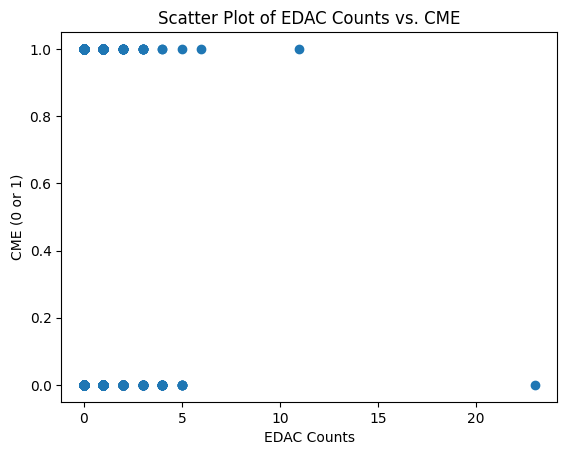

In [9]:
plt.scatter(df['EDAC'], df['cme'])
plt.xlabel('EDAC Counts')
plt.ylabel('CME (0 or 1)')
plt.title('Scatter Plot of EDAC Counts vs. CME')
plt.show()

Trend Analysis: If there was a clear trend or pattern, such as a distinct increase in EDAC counts with the presence of CME events, it would be visible in the scatter plot. However, from this visualization, it doesn't appear that there is a strong and obvious linear relationship since the points for y=1 are not consistently higher in EDAC counts than those for y=0.

## Neural net models with Pytorch

In [10]:
class EDACDataset(Dataset):
    """Custom Dataset for loading EDAC data"""
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [11]:
# Preprocess the data
# df['EDAC'] = StandardScaler().fit_transform(df[['EDAC']])
# X = df['EDAC'].values
# y = df['cme'].values

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.astype(np.float32)).unsqueeze(1)
y_train = torch.tensor(y_train.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32)).unsqueeze(1)
y_test = torch.tensor(y_test.astype(np.float32))

In [13]:
# Calculate the weight for the positive class
class_counts = df['cme'].value_counts()
weight_for_1 = (1 / class_counts[1]) * (len(df) / 2.0)
class_weight = torch.tensor([weight_for_1]).float()

In [14]:
def evaluate_model_with_f1(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            predicted = (outputs.squeeze() > 0.5).float()
            all_predictions.extend(predicted.tolist())
            all_targets.extend(target.tolist())

    # Calculate metrics
    accuracy = (np.array(all_predictions) == np.array(all_targets)).mean()
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    return accuracy, precision, recall, f1

In [15]:
# Create DataLoaders
train_dataset = EDACDataset(X_train, y_train)
test_dataset = EDACDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Neural Network Model
class EDACNet(nn.Module):
    def __init__(self):
        super(EDACNet, self).__init__()
        self.fc1 = nn.Linear(1, 10)  # Adjust the number of neurons
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)  # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model
model = EDACNet()

# Loss and Optimizer
criterion = nn.BCELoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            predicted = (outputs.squeeze() > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy}%')

# Note: This code is a basic template and might need adjustments based on your actual dataset.


Epoch 1, Loss: 2.857212493914893
Epoch 2, Loss: 2.5224304377541498
Epoch 3, Loss: 2.522657038353648
Epoch 4, Loss: 2.5226548335530645
Epoch 5, Loss: 2.522590469805219
Epoch 6, Loss: 2.5226513884110036
Epoch 7, Loss: 2.522955100485519
Epoch 8, Loss: 2.5225262230856793
Epoch 9, Loss: 2.5227583692129136
Epoch 10, Loss: 2.5223924705938217
Accuracy: 98.26833282945346%


In [16]:
accuracy, precision, recall, f1 = evaluate_model_with_f1(model, test_loader)
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Accuracy: 0.9827, Precision: 0.5000, Recall: 0.0003, F1 Score: 0.0006


## LSTM

In [17]:
# Create the sequences with a window size of 36 (3 hours at 5 minutes per interval)
window_size = 36  # 3 hours * 60 minutes / 5 minutes per interval
X_sequence, y_sequence = create_sliding_window_sequences(X, y, window_size)

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequence, y_sequence, test_size=0.2, random_state=42)

In [19]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train[:, :, np.newaxis], dtype=torch.float32)  # Adding an extra dimension for LSTM input
y_train_tensor = torch.tensor(y_train[:, np.newaxis], dtype=torch.float32)  # Adding an extra dimension for LSTM output
X_test_tensor = torch.tensor(X_test[:, :, np.newaxis], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test[:, np.newaxis], dtype=torch.float32)

In [20]:
# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Instantiate the model
hidden_dim = 64
num_layers = 1
model = CMEPredictorLSTM(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers)

# Define the loss function and optimizer
criterion = nn.BCELoss() # Default
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training and evaluation

In [22]:
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/30, Loss: 0.16208432614803314
Epoch 2/30, Loss: 0.15603922307491302
Epoch 3/30, Loss: 0.08715824782848358
Epoch 4/30, Loss: 0.1595345139503479
Epoch 5/30, Loss: 0.15877753496170044
Epoch 6/30, Loss: 0.0164636243134737
Epoch 7/30, Loss: 0.08726794272661209
Epoch 8/30, Loss: 0.014458577148616314
Epoch 9/30, Loss: 0.08719978481531143
Epoch 10/30, Loss: 0.019636793062090874
Epoch 11/30, Loss: 0.01625734195113182
Epoch 12/30, Loss: 0.017482275143265724
Epoch 13/30, Loss: 0.08742906898260117
Epoch 14/30, Loss: 0.015229837968945503
Epoch 15/30, Loss: 0.016985246911644936
Epoch 16/30, Loss: 0.08731164038181305
Epoch 17/30, Loss: 0.021854175254702568
Epoch 18/30, Loss: 0.08728744834661484
Epoch 19/30, Loss: 0.15459194779396057
Epoch 20/30, Loss: 0.0871344655752182
Epoch 21/30, Loss: 0.015069413930177689
Epoch 22/30, Loss: 0.08745097368955612
Epoch 23/30, Loss: 0.15746046602725983
Epoch 24/30, Loss: 0.22909532487392426
Epoch 25/30, Loss: 0.15996423363685608
Epoch 26/30, Loss: 0.087874725

In [28]:
# Evaluation loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_true = y_test_tensor.numpy()
    y_pred = model(X_test_tensor).numpy()
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9825
Precision: 1.0000
Recall: 0.0019
F1 Score: 0.0038


## LSTM with class weights

In [34]:
# Calculate the class weights for imbalanced classes
class_counts = df['cme'].value_counts().sort_index().values
weight_for_1 = (1 / class_counts[1]) * (len(df) / 2.0)
weights = torch.tensor([weight_for_1], dtype=torch.float32)

# Define the weighted loss function with pos_weight for the positive class
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

In [36]:
# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass, use model with logits output (not passing through sigmoid)
        outputs = model(inputs).squeeze()
        
        # Compute the loss, labels should be float and no need to squeeze if they are already 1D
        loss = criterion(outputs, labels.float().view(-1))

        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/2, Loss: 1.661719799041748
Epoch 2/2, Loss: 1.6617088317871094


In [38]:
# Evaluation loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_true = y_test_tensor.numpy()
    y_pred = model(X_test_tensor).numpy()
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9824
Precision: 0.4409
Recall: 0.0131
F1 Score: 0.0255
